# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Useful Functions

In [2]:
def plot_time_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Create Time Series

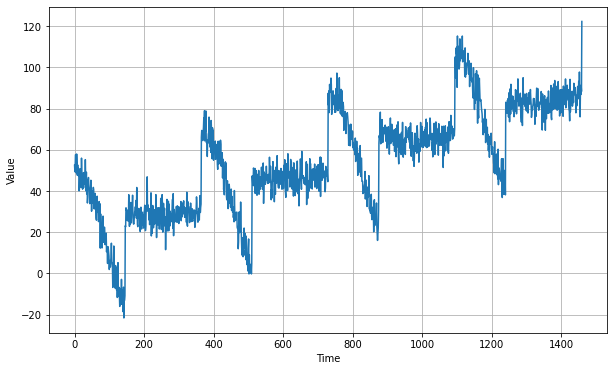

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")

baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
period = 365

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

# Splitting Time Series

In [4]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# Creating windowed dataset

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


# **LSTM Model**

# Find Learning Rate & Create Model

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model_lstm = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model_lstm.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
  metrics = ['mae']
)

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [10]:
history_lstm = model_lstm.fit(dataset,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 63ms/step - loss: 72.6562 - mae: 73.1562
Epoch 2/100
8/8 [==============================] - 1s 52ms/step - loss: 72.5335 - mae: 73.0335
Epoch 3/100
8/8 [==============================] - 1s 52ms/step - loss: 72.3362 - mae: 72.8362
Epoch 4/100
8/8 [==============================] - 1s 52ms/step - loss: 72.0903 - mae: 72.5903
Epoch 5/100
8/8 [==============================] - 1s 50ms/step - loss: 71.8033 - mae: 72.3033
Epoch 6/100
8/8 [==============================] - 1s 51ms/step - loss: 71.4768 - mae: 71.9768
Epoch 7/100
8/8 [==============================] - 1s 51ms/step - loss: 71.1067 - mae: 71.6067
Epoch 8/100
8/8 [==============================] - 1s 54ms/step - loss: 70.6933 - mae: 71.1933
Epoch 9/100
8/8 [==============================] - 1s 51ms/step - loss: 70.2269 - mae: 70.7269
Epoch 10/100
8/8 [==============================] - 1s 54ms/step - loss: 69.7031 - mae: 70.2031
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

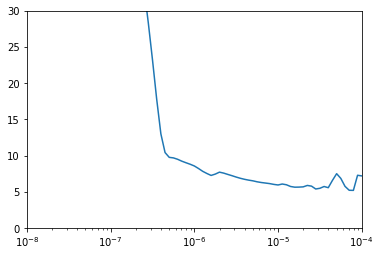

In [13]:
plt.semilogx(history_lstm.history["lr"], 
             history_lstm.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model_lstm = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model_lstm.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
  metrics = ['mae']
)

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_lstm.layers[0].output_shape

(None, None, 1)

In [25]:
model_lstm.layers[0].input_shape

(None, None)

In [15]:
history_lstm = model_lstm.fit(dataset,
                    epochs=500)

Epoch 1/500
8/8 [==============================] - 7s 51ms/step - loss: 50.0713 - mae: 50.5699
Epoch 2/500
8/8 [==============================] - 1s 49ms/step - loss: 20.4412 - mae: 20.9375
Epoch 3/500
8/8 [==============================] - 0s 50ms/step - loss: 15.3663 - mae: 15.8576
Epoch 4/500
8/8 [==============================] - 1s 48ms/step - loss: 12.8232 - mae: 13.3140
Epoch 5/500
8/8 [==============================] - 1s 49ms/step - loss: 10.2693 - mae: 10.7585
Epoch 6/500
8/8 [==============================] - 0s 51ms/step - loss: 8.4809 - mae: 8.9654
Epoch 7/500
8/8 [==============================] - 1s 51ms/step - loss: 7.4297 - mae: 7.9133
Epoch 8/500
8/8 [==============================] - 0s 48ms/step - loss: 7.0212 - mae: 7.5025
Epoch 9/500
8/8 [==============================] - 1s 50ms/step - loss: 6.7714 - mae: 7.2520
Epoch 10/500
8/8 [==============================] - 1s 49ms/step - loss: 6.5884 - mae: 7.0699
Epoch 11/500
8/8 [==============================] - 0s 46ms

In [16]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model_lstm.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


print(len(results))

461


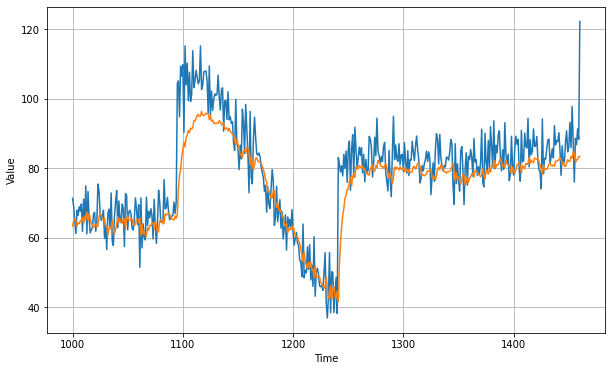

In [17]:
plt.figure(figsize=(10, 6))

plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, results)

# Loss

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.9003305

# Plot Loss

<Figure size 432x288 with 0 Axes>

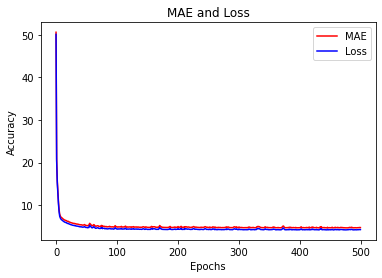

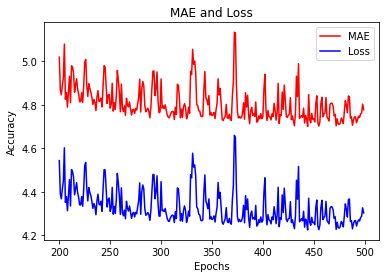

<Figure size 432x288 with 0 Axes>

In [26]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_lstm.history['mae']
loss=history_lstm.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()